In [2]:
import pandas as pd
import numpy as np

# Plotting and correlation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy import stats

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

Compilation of final data analyses based on exploratory notebooks. We generate realistic electricity-powered vehicle numbers based on different EV proportions in two different ways. We predict electricity demand in California based on these distributions and calculate energy generation-related emissions.

**Load data**

In [515]:
# monthly CA CO2 emissions (mTCO2)

emissions = pd.read_csv('data/cleaned/monthly_emissions_reformat.csv')
emissions.rename(columns={'Unnamed: 0':'date'},inplace=True)
print(f'shape: {emissions.shape}')
emissions.head()


shape: (99, 2)


,date,emissions
0,201401,5615497.820
1,201402,5022762.297
2,201403,5289480.524
3,201404,4812433.460
4,201405,5331965.630


In [473]:
# CA monthly demand (MWh)

demand = pd.read_csv('data/cleaned/monthly_demand.csv')
demand = demand.rename(columns={'Unnamed: 0':'date'})

print(f'shape: {demand.shape}')
demand.head()

shape: (89, 2)


,date,demand
0,202211,18098856
1,202210,22583054
2,202209,27240453
3,202208,29002852
4,202207,26935101


In [447]:
# CA monthly vehicle distribution

fuel_types = ['electric','plug-in hybrid electric','fuel cell','diesel','flex fuel','gasoline','gasoline hybrid','natural gas fuel','propane']

vehicles = pd.read_csv('data/cleaned/monthly_vehicles.csv')
vehicles = vehicles.drop(columns=['Unnamed: 0']) 
vehicles.head()

,date,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas fuel,propane,total,date_idx
0,202112,522445,305315,10127,590216,1208970,25998618,1298275,8461,90,29942517,132
1,202111,505951,300973,9877,599395,1203600,25917181,1285769,8395,157,29836132,131
2,202110,490400,297256,9627,608574,1198231,25835745,1275167,8330,224,29729751,130
3,202109,476248,292462,9377,617753,1192861,25754308,1263823,8264,291,29623366,129
4,202108,462251,289169,9127,626932,1187492,25672872,1253083,8199,359,29516987,128


In [448]:
# monthly maximum temperature in each CA county (degrees Fahrenheit)

tmax = pd.read_csv('data/cleaned/monthly_tmax_reformat.csv')
tmax = tmax.drop(columns=['Unnamed: 0'])

print(tmax.shape)
tmax.head()

(95, 61)


,date,county 1 tmax,county 3 tmax,county 5 tmax,county 7 tmax,county 9 tmax,county 11 tmax,county 13 tmax,county 15 tmax,county 17 tmax,...,county 101 tmax,county 103 tmax,county 105 tmax,county 107 tmax,county 109 tmax,county 111 tmax,county 113 tmax,county 115 tmax,mean tmax,date_idx
0,201501,61.0,48.5,59.9,61.0,60.2,61.9,60.1,54.7,57.2,...,60.6,61.0,54.5,53.1,54.4,64.1,61.2,61.4,59.558621,1
1,201502,65.4,50.9,63.7,65.3,64.8,67.3,66.1,55.9,59.4,...,67.8,63.5,57.6,60.8,57.4,66.4,67.3,66.3,64.100000,2
2,201503,70.8,53.5,69.3,71.3,70.0,74.6,72.2,60.7,63.8,...,76.1,69.1,64.1,65.5,60.7,71.4,74.5,72.5,69.410345,3
3,201504,69.6,52.2,68.4,72.2,69.3,76.2,71.6,60.9,63.1,...,78.1,70.8,64.9,65.1,59.6,68.6,76.8,73.3,69.055172,4
4,201505,68.8,55.9,72.7,76.8,73.2,80.0,71.1,67.3,67.5,...,81.5,75.4,71.7,67.9,62.3,68.7,79.4,77.7,71.446552,5


In [449]:
# monthly average precipitation in each CA county (inches)

precip = pd.read_csv('data/cleaned/monthly_precip_reformat.csv')
precip = precip.drop(columns=['Unnamed: 0'])

print(precip.shape)
precip.head()

(95, 61)


,date,county 1 precip,county 3 precip,county 5 precip,county 7 precip,county 9 precip,county 11 precip,county 13 precip,county 15 precip,county 17 precip,...,county 101 precip,county 103 precip,county 105 precip,county 107 precip,county 109 precip,county 111 precip,county 113 precip,county 115 precip,mean precip,date_idx
0,201501,0.01,0.22,0.14,0.21,0.13,0.18,0.01,3.49,0.12,...,0.10,0.25,1.79,0.47,0.14,1.97,0.06,0.08,0.440345,1
1,201502,2.25,5.53,5.36,4.58,5.26,3.66,2.34,11.17,6.96,...,2.49,4.29,11.74,2.29,5.12,0.88,3.20,4.42,3.597241,2
2,201503,0.26,0.62,0.83,0.58,0.64,0.54,0.26,5.65,0.87,...,0.17,1.04,2.53,0.43,0.68,0.69,0.17,0.48,0.722759,3
3,201504,1.15,2.52,3.09,2.24,2.64,1.78,1.09,4.36,3.41,...,1.52,1.76,2.03,0.87,3.29,0.32,1.31,2.75,1.556897,4
4,201505,0.37,2.99,1.39,0.29,1.18,0.08,0.20,0.68,1.96,...,0.03,0.61,1.23,1.76,2.70,0.61,0.10,0.17,0.862759,5


**Generate vehicle distribution**

From 4_vehicle_prediction.ipynb. Given a date and a set of growth rates for each vehicle type, predict vehicle distribution. We also get the average temperature and precipitation for that month

In [413]:
# Get dataset
df = vehicles
df.head()

,date,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas fuel,propane,total,date_idx
0,202112,522445,305315,10127,590216,1208970,25998618,1298275,8461,90,29942517,132
1,202111,505951,300973,9877,599395,1203600,25917181,1285769,8395,157,29836132,131
2,202110,490400,297256,9627,608574,1198231,25835745,1275167,8330,224,29729751,130
3,202109,476248,292462,9377,617753,1192861,25754308,1263823,8264,291,29623366,129
4,202108,462251,289169,9127,626932,1187492,25672872,1253083,8199,359,29516987,128


In [414]:
# given date of YEARMONTH format, get date_idx

NUM_MONTHS = 12
FIRST_YEAR = 2014

def to_index(date):
    date_year = int(str(date)[0:4])
    if date_year < 2014:
        print('Date must be 2014 or later')
    date_month = int(str(date)[4:6])
    if date_month < 0 or date_month > NUM_MONTHS:
        print('Invalid month')
    months_to_curr_year = (date_year - FIRST_YEAR) * NUM_MONTHS
    date_idx = months_to_curr_year + date_month - 1
    return date_year, date_month, date_idx 


In [416]:
# given date of YEARMONTH format and which fits to use for each vehicle type, predict vehicle distribution

def predict_distribution(date, fit_list):
    year, month, test_date_idx = to_index(date)

    print(f'In month {month} of {year} or date index {test_date_idx}, we predict:')

    X = df['date_idx']
    vehicle_distribution = {}
    for fuel in fuel_types:
        y = df[fuel]
        fit = fit_list[fuel]
        poly_model = np.poly1d(np.polyfit(X, y, fit))
        predicted_vehicles = int(poly_model(test_date_idx))
        if predicted_vehicles < 0:
            predicted_vehicles = 0
        vehicle_distribution[fuel] = predicted_vehicles

    total_vehicles = sum(list(vehicle_distribution.values()))
    print(f'Total vehicles: {total_vehicles}')
    for vehicle in vehicle_distribution:
        num_vehicles = vehicle_distribution[vehicle]
        percentage = round(num_vehicles/total_vehicles * 100, 2)
        print(f'Estimated number of {vehicle} vehicles: {num_vehicles} or {percentage}%')
    
    return test_date_idx, vehicle_distribution

In [401]:
# Given a date, find the average max. temperature and precipitation for that month
def weather_avg(date):
    month = str(date)[4:]
    date_idx = int(month)
    tmax_sum = 0
    precip_sum = 0
    counter = 0
    while date_idx in list(tmax['date_idx']):
        tmax_sum += float(tmax.loc[tmax['date_idx'] == date_idx, 'mean tmax'])
        precip_sum += float(precip.loc[precip['date_idx'] == date_idx, 'mean precip'])
        date_idx += 12
        counter += 1
    tmax_avg = tmax_sum/counter
    precip_avg = precip_sum/counter
    return tmax_avg, precip_avg

In [418]:
# input
date = 202608 # December 2026

fit_list = {
    'electric': 3, # 2 = least optimistic, 5 = most optimistic
    'plug-in hybrid electric': 3,
    'fuel cell': 3,
    'gasoline hybrid': 3,
    'flex fuel': 2,
    'gasoline': 2,
    'diesel': 4,
    'natural gas fuel': 4,
    'propane': 4
}

# get vehicle prediction
test_date_idx, vehicle_distribution = predict_distribution(date, fit_list)

# get weather averages
tmax_avg, precip_avg = weather_avg(date)
print()
print(f'In month {str(date)[4:]}, average for 2015-2022:')
print(f'Max temperature : {round(tmax_avg,2)}')
print(f'Precipitation: {round(precip_avg,2)}')

In month 8 of 2026 or date index 151, we predict:
Total vehicles: 31489867
Estimated number of electric vehicles: 699835 or 2.22%
Estimated number of plug-in hybrid electric vehicles: 312033 or 0.99%
Estimated number of fuel cell vehicles: 12573 or 0.04%
Estimated number of diesel vehicles: 379989 or 1.21%
Estimated number of flex fuel vehicles: 1224642 or 3.89%
Estimated number of gasoline vehicles: 27575770 or 87.57%
Estimated number of gasoline hybrid vehicles: 1276945 or 4.06%
Estimated number of natural gas fuel vehicles: 8080 or 0.03%
Estimated number of propane vehicles: 0 or 0.0%

In month 08, average for 2015-2022:
Max temperature : 88.93
Precipitation: 0.1


In [ ]:
predicted_weather = [tmax_avg, precip_avg]

predicted_electric = vehicle_distribution['electric']
predicted_plug_in_hybrid = vehicle_distribution['plug-in hybrid electric']

# input for next step
demand_input = [predicted_electric, predicted_plug_in_hybrid] + predicted_weather

**Predicting demand**

From 3_vehicle_to_demand.ipynb. Predict electricity demand for CA given the number of EVs, number of plug-in hyrid, and weather data generated above

In [464]:
# Get dataset

df = demand.merge(vehicles)
df = df.merge(tmax[['date','mean tmax']], left_on='date', right_on='date')
df = df.merge(precip[['date','mean precip']], left_on='date', right_on='date')

print(df.shape)
df.head()

(78, 15)


,date,demand,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas fuel,propane,total,date_idx,mean tmax,mean precip
0,202112,22418337,522445,305315,10127,590216,1208970,25998618,1298275,8461,90,29942517,132,51.368966,8.301379
1,202111,20251317,505951,300973,9877,599395,1203600,25917181,1285769,8395,157,29836132,131,64.374138,1.324310
2,202110,21604672,490400,297256,9627,608574,1198231,25835745,1275167,8330,224,29729751,130,69.306897,5.433276
3,202109,24859626,476248,292462,9377,617753,1192861,25754308,1263823,8264,291,29623366,129,84.768966,0.344828
4,202108,27525448,462251,289169,9127,626932,1187492,25672872,1253083,8199,359,29516987,128,88.951724,0.057241


In [465]:
# EVs, plug-in hybrids, tmax, precip -> electricity demand

# Best parameters: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 7}

X = df[['electric','plug-in hybrid electric','mean tmax','mean precip']]
y = df['demand']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

rf_model = RandomForestRegressor(n_estimators=200,min_samples_split=4,min_samples_leaf=1,max_features='log2',max_depth=5)             
rf_model.fit(X_train,  y_train)

print(f'Input: {list(X.columns)}')
print(f'model score on training data : {rf_model.score(X_train,  y_train)}')
print(f'model score on testing data: {rf_model.score(X_test, y_test)}')

Input: ['electric', 'plug-in hybrid electric', 'mean tmax', 'mean precip']
model score on training data : 0.9601783726511156
model score on testing data: 0.851121026421332


In [466]:
# Lasso

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

print(f'Training data score: {lasso.score(X_train,  y_train)}')
print(f'Testing data score: {lasso.score(X_test, y_test)}')

Training data score: 0.7648531843785259
Testing data score: 0.5764671033491959


In [467]:
# Stacking linear regressor and Random Forest

estimators = [
    ("Linear Regression", lasso),
    ("Random Forest", rf_model),
]
demand_model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

demand_model.fit(X,y)
print(f'Training data score: {demand_model.score(X_train,  y_train)}')
print(f'Testing data score: {demand_model.score(X_test, y_test)}')

Training data score: 0.9523475467006872
Testing data score: 0.9415412051814204


In [468]:
# use above model and vehicle distribution generated from previous step

def predict_demand(demand_model, demand_input):
    prediction = demand_model.predict([demand_input])[0]
    return prediction

prediction = predict_demand(demand_model, demand_input)
predicted_demand = prediction
print(f'The predicted monthly demand in California given a distribution of vehicles is {round(prediction,2)} MWh')

The predicted monthly demand in California given a distribution of vehicles is 27865230.45 MWh


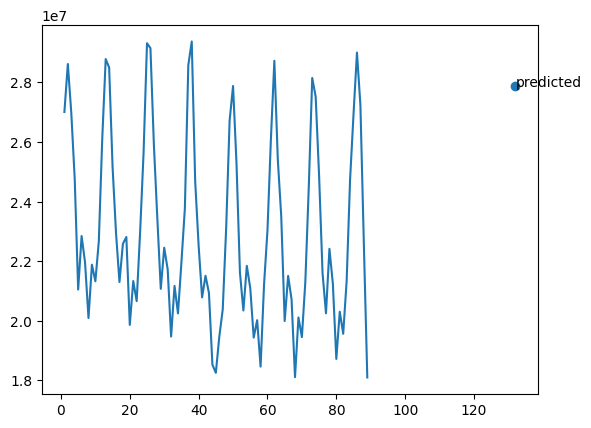

In [520]:
# See predicted demand compared to past

# Add date index column for graphing
demand['date_idx'] = ''
height = demand.shape[0]
for index, row in demand.iterrows():
    demand.loc[demand['date'] == row['date'] , 'date_idx'] = height - index

# change date index to match demand date indices (demand index starts July 2015, whereas the original index started Jan 2014)
MONTH_DIFFERENCE = 19
converted_test_date_idx = test_date_idx - MONTH_DIFFERENCE

plt.plot(demand['date_idx'],demand['demand'])
plt.scatter(converted_test_date_idx,predicted_demand)
plt.annotate('predicted',(converted_test_date_idx,predicted_demand))
plt.show()

In [521]:
# Context for this prediction

MOST_RECENT_YEAR = '2021'

# Get average demand in given month
def month_avg_demand(month):
    date_idx = int(month)
    sum = 0
    counter = 0
    while date_idx in list(demand['date_idx']):
        sum += float(demand.loc[demand['date_idx'] == date_idx, 'demand'])
        date_idx += 12
        counter += 1
    average = sum/counter
    return average

# Get demand from same month in 2021
def recent_month_demand(month):
    full_date =  MOST_RECENT_YEAR + month
    return float(demand.loc[demand['date'] == int(full_date), 'demand'])

month = str(date)[4:]
month_avg_demand = month_avg_demand(month)
recent_month_demand = recent_month_demand(month)
demand = demand.drop(columns='date_idx')

print(f'On average, CA demand in month {month} over the last 8 years is {round(month_avg_demand,2)} MWh, and the demand from month {month} of 2021 was {recent_month_demand} MWh')
print(f'Predicted value: {round(predicted_demand,2)} MWh')
print(f'This is an increase of {round((predicted_demand - recent_month_demand),2)} MWh from 2021')

On average, CA demand in month 08 over the last 8 years is 19175146.29 MWh, and the demand from month 08 of 2021 was 27525448.0 MWh
Predicted value: 27865230.45 MWh
This is an increase of 339782.45 MWh from 2021


**Predicting emissions**

From 2_emissions_prediction.ipynb. Using previously generated vehicle distribution and predicted demand, predict final monthly emissions for the given date

In [522]:
# Get dataset
df = demand.merge(emissions)
df = df.merge(vehicles)
df = df.drop(columns=['total','date_idx','date'])

print(df.shape)
df.head()

(78, 11)


,demand,emissions,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas fuel,propane
0,22418337,4959996.71,522445,305315,10127,590216,1208970,25998618,1298275,8461,90
1,20251317,4365100.13,505951,300973,9877,599395,1203600,25917181,1285769,8395,157
2,21604672,4577134.35,490400,297256,9627,608574,1198231,25835745,1275167,8330,224
3,24859626,5070292.57,476248,292462,9377,617753,1192861,25754308,1263823,8264,291
4,27525448,5607233.68,462251,289169,9127,626932,1187492,25672872,1253083,8199,359


In [524]:
# Random forest regressor. Input: demand, vehicle distributions; output: emissions
# Best parameters: {'n_estimators': 50, 'max_features': 'sqrt'}

X = df.drop(columns=['emissions'])
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rf_model = RandomForestRegressor(n_estimators=50,max_features='sqrt')
rf_model.fit(X_train,  y_train)

print(f'Input: {list(X.columns)}')
print(f'Training data score: {rf_model.score(X_train,  y_train)}')
print(f'Testing data score: {rf_model.score(X_test, y_test)}')

Input: ['demand', 'electric', 'plug-in hybrid electric', 'fuel cell', 'diesel', 'flex fuel', 'gasoline', 'gasoline hybrid', 'natural gas fuel', 'propane']
Training data score: 0.9530487594793191
Testing data score: 0.7756646090761297


In [525]:
# Lasso

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)

print(f'Training data score: {lasso.score(X_train,  y_train)}')
print(f'Testing data score: {lasso.score(X_test, y_test)}')

Training data score: 0.6776635902743109
Testing data score: 0.6267093969613656


In [526]:
estimators = [
    ("Lasso", lasso),
    ("Random Forest", rf_model),
]

emissions_model = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

emissions_model.fit(X,y)
print(f'Training data score: {emissions_model.score(X_train,  y_train)}')
print(f'Testing data score: {emissions_model.score(X_test, y_test)}')


Training data score: 0.9485679576388408
Testing data score: 0.9513488843150455


In [527]:
# use above model and vehicle distribution generated from previous step

def predict_emissions(emissions_model, emissions_input):
    prediction = emissions_model.predict([emissions_input])[0]
    return prediction

emissions_input = [predicted_demand] + list(vehicle_distribution.values())

prediction = predict_emissions(emissions_model, emissions_input)
predicted_emissions = prediction
print(f'The predicted monthly emissions in California is {round(prediction,2)} megatons of CO2')

The predicted monthly emissions in California is 5940625.1 megatons of CO2


**In context**

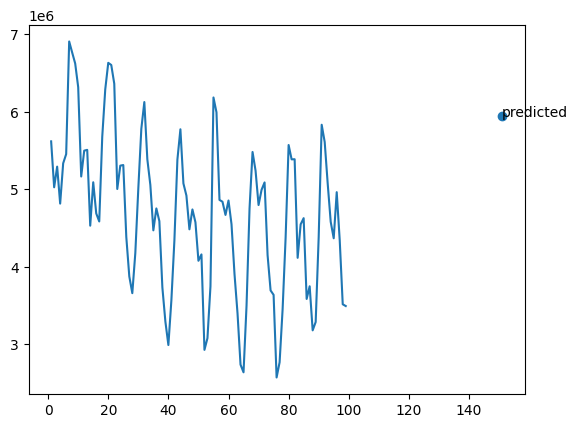

In [530]:
# print graph showing predicted emissions compared to past emissions

# add date index to emissions for graphing
emissions['date_idx'] = ''
for index, row in emissions.iterrows():
    emissions.loc[emissions['date'] == row['date'] , 'date_idx'] = index + 1

plt.plot(emissions['date_idx'],emissions['emissions'])
plt.scatter(test_date_idx,predicted_emissions)
plt.annotate('predicted',(test_date_idx,predicted_emissions))
plt.show()

In [531]:
# Context

# get average emissions for given month
def month_avg_emissions(month_num):
    date_idx = int(month_num)
    sum = 0
    counter = 0
    while date_idx in list(emissions['date_idx']):
        sum += float(emissions.loc[emissions['date_idx'] == date_idx, 'emissions'])
        date_idx += 12
        counter += 1
    average = sum/counter
    return average

# Get emissions from same month in 2021
def recent_month_demand(month):
    full_date =  MOST_RECENT_YEAR + month
    return float(emissions.loc[emissions['date'] == int(full_date), 'emissions'])

month = str(date)[4:]
month_avg_emissions = month_avg_emissions(month)
recent_month_emissions = recent_month_demand(month)
emissions = emissions.drop(columns='date_idx')

print(f'On average, CA emissions in month {month} over the last 8 years is {round(month_avg_emissions,2)} mTCO2, and the emissions from month {month} of 2021 was {recent_month_emissions} mTCO2')
print(f'Predicted value: {round(predicted_emissions,2)}')
print(f'This is an increase of {round((predicted_emissions - recent_month_emissions),2)} mTCO2 from 2021')

On average, CA emissions in month 08 over the last 8 years is 5990974.48 mTCO2, and the emissions from month 08 of 2021 was 5607233.68 mTCO2
Predicted value: 5940625.1
This is an increase of 333391.42 mTCO2 from 2021
